# Natural Language Processing

Projet de NLP pour la prédiction des décisions judiciaires de la cour de cassation française. Les données proviennent de l'API du ministère de la Justice.

#   Importation 
##  Les packages

In [1]:
import pandas as pd
import numpy as np
import string
import nltk # to use the stopwords library
import spacy # for our NLP processing
import gensim
from nltk.corpus import stopwords  # for a list of stopwords
from sklearn.manifold import TSNE
import re
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as pyo

from PIL import Image
from plotly.offline import init_notebook_mode, iplot
from unidecode import unidecode
import plotly.io as pio


##  La base

In [2]:
data_set = pd.read_csv("data_nlp.csv", index_col= 0)
data_set["Date"] = pd.to_datetime(data_set["Date"])
data_set.head(5)

,Texte,Decision,Date,Categorie
0,REJET DU POURVOI REGULIEREMENT FORME PAR X... ...,rejet,1963-01-04,abus
1,CASSATION SUR LES POURVOIS DE : 1° X... (JEAN)...,cassation,1963-01-29,abus
2,CASSATION PARTIELLE SUR LE POURVOI DE X... (MA...,cassation,1963-02-26,abus
3,"REJET DU POURVOI DE X... (HUGUES), CONTRE UN A...",rejet,1963-06-11,abus
4,REJET ET CASSATION PARTIELLE SUR LES POURVOIS ...,cassation,1963-06-27,abus


#   Quelques visualisations ...

##  Les catégories

In [3]:
data_set["Categorie"].value_counts()

homicide    683
abus        489
vol         426
Name: Categorie, dtype: int64

Le présent graphique a été conçu pour être dynamique dans un environnement jupyter. Il a été enregistré et afficher en pdf pour permettre son intégration dans un fichier pdf

C:\Users\Paqua\AppData\Local\Temp\ipykernel_19492\1596399148.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



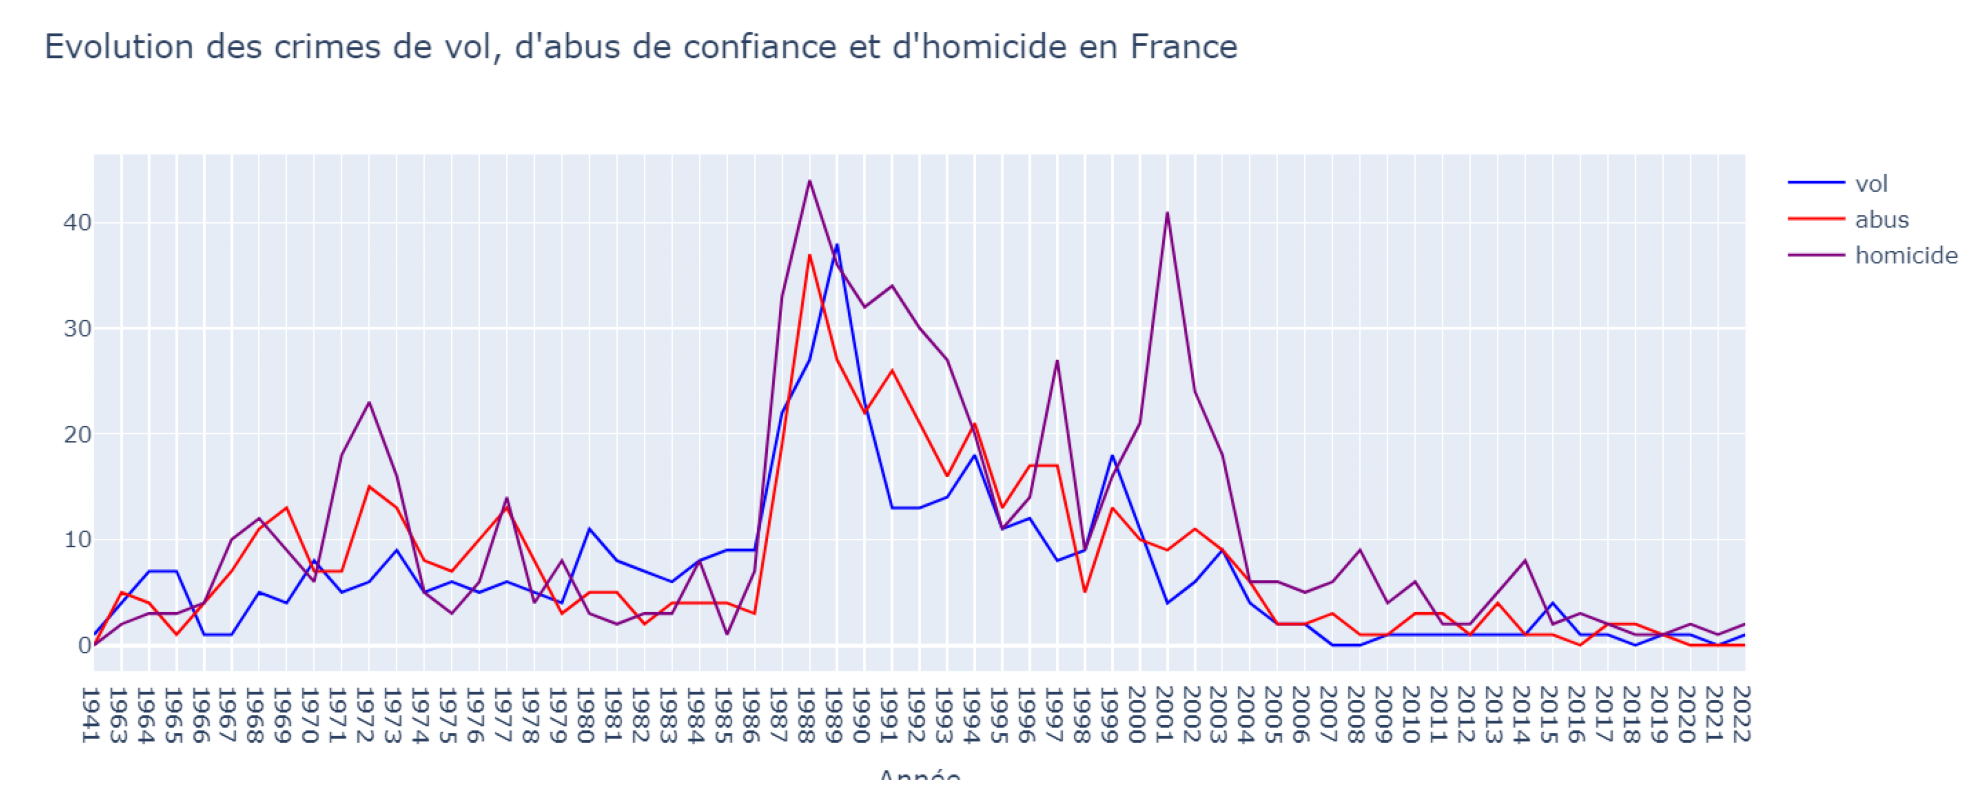

In [10]:
test = data_set[["Date", "Categorie"]]
test["Date"] = test["Date"].dt.strftime('%Y')
test.sort_values("Date")
test.head(5)
counts = test.groupby(['Date', 'Categorie']).size().unstack(fill_value=0)
init_notebook_mode(connected=True)
sns.set_theme(style="whitegrid")
plt.figure(figsize=(30, 10))
trace1 = go.Scatter(x=counts.index, y=counts["vol"], mode="lines", line=dict(width=1.5, color="blue"), name= "vol")
trace2 = go.Scatter(x=counts.index, y=counts["abus"], mode="lines", line=dict(width=1.5, color="red"), name= "abus")
trace3 = go.Scatter(x=counts.index, y=counts["homicide"], mode="lines", line=dict(width=1.5, color="purple"), name= "homicide")
data = [trace1, trace2, trace3]
layout = go.Layout(title="Evolution des crimes de vol, d'abus de confiance et d'homicide en France", xaxis=dict(title="Année"), yaxis=dict(title=""))
fig = go.Figure(data=data, layout=layout)
#iplot(fig)
del test, counts, data, trace1, trace2, trace3
from IPython.display import Image
import matplotlib.image as mpimg

img = mpimg.imread("graphe1.png")
plt.axis("off")
plt.imshow(img)
plt.show()

##  Les décisions rendues

In [11]:
data_set["Decision"].value_counts()

rejet             1093
cassation          447
other               33
annulation          13
irrecevabilite      11
reglement            1
Name: Decision, dtype: int64

C:\Users\Paqua\AppData\Local\Temp\ipykernel_19492\796229410.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



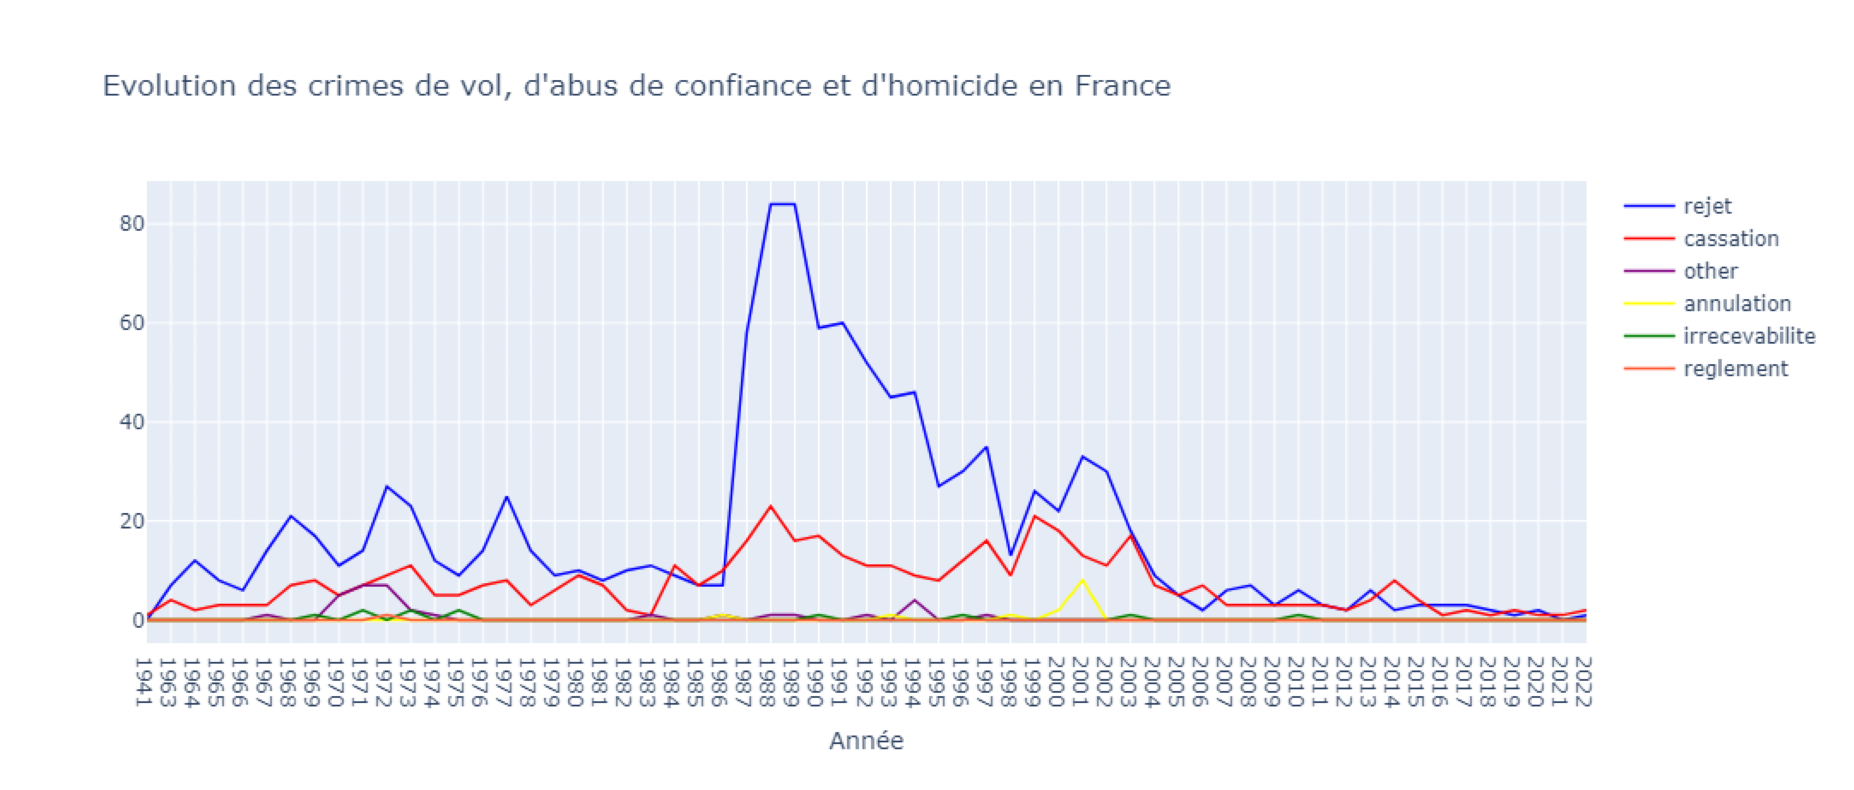

In [13]:
test = data_set[["Date", "Decision"]]
test["Date"] = test["Date"].dt.strftime('%Y')
test.sort_values("Date")
test.head(5)
counts = test.groupby(['Date', 'Decision']).size().unstack(fill_value=0)
init_notebook_mode(connected=True)
sns.set_theme(style="whitegrid")
plt.figure(figsize=(30, 10))
trace1 = go.Scatter(x=counts.index, y=counts["rejet"], mode="lines", line=dict(width=1.5, color="blue"), name= "rejet")
trace2 = go.Scatter(x=counts.index, y=counts["cassation"], mode="lines", line=dict(width=1.5, color="red"), name= "cassation")
trace3 = go.Scatter(x=counts.index, y=counts["other"], mode="lines", line=dict(width=1.5, color="purple"), name= "other")
trace4 = go.Scatter(x=counts.index, y=counts["annulation"], mode="lines", line=dict(width=1.5, color="yellow"), name= "annulation")
trace5 = go.Scatter(x=counts.index, y=counts["irrecevabilite"], mode="lines", line=dict(width=1.5, color="green"), name= "irrecevabilite")
trace6 = go.Scatter(x=counts.index, y=counts["reglement"], mode="lines", line=dict(width=1.5, color="#FF5933"), name= "reglement")
data = [trace1, trace2, trace3, trace4, trace5, trace6]
layout = go.Layout(title="Evolution des crimes de vol, d'abus de confiance et d'homicide en France", xaxis=dict(title="Année"), yaxis=dict(title=""))
fig = go.Figure(data=data, layout=layout)
#iplot(fig)

img = mpimg.imread("graphe2.png")
plt.axis("off")
plt.imshow(img)
plt.show()

del test, counts, data, trace1, trace2, trace3, trace4, trace5, trace6, fig, layout

# Nettoyage de la base
Suppression des décisions other, d'annulation, de règlement et d'irrecevabilite

In [14]:
print("Dimension de la base : ", data_set.shape)
data_set = data_set.drop(data_set[(data_set["Decision"] == "other") | (data_set["Decision"] == "annulation") | (data_set["Decision"] == "irrecevabilite") | (data_set["Decision"] == "reglement")].index)
print("Nouvelle dimension de la base : ", data_set.shape)

Dimension de la base :  (1598, 4)
Nouvelle dimension de la base :  (1540, 4)


In [15]:
data_set["Decision"].value_counts()

rejet        1093
cassation     447
Name: Decision, dtype: int64

In [16]:
data_set.head()

,Texte,Decision,Date,Categorie
0,REJET DU POURVOI REGULIEREMENT FORME PAR X... ...,rejet,1963-01-04,abus
1,CASSATION SUR LES POURVOIS DE : 1° X... (JEAN)...,cassation,1963-01-29,abus
2,CASSATION PARTIELLE SUR LE POURVOI DE X... (MA...,cassation,1963-02-26,abus
3,"REJET DU POURVOI DE X... (HUGUES), CONTRE UN A...",rejet,1963-06-11,abus
4,REJET ET CASSATION PARTIELLE SUR LES POURVOIS ...,cassation,1963-06-27,abus


## Nettoyage du texte
On a pris la décision de supprimer les retours à la ligne, ainsi qu'un certains nombre de caractère spéciaux tels que `"_"` et les chiffres

In [19]:
def clean_text(text):
    text = re.sub(r'[^\w\s]', ' ', text) # Supprime les caractères spéciaux
    text = re.sub(r'\d', '', text) # Supprime les chiffres
    text = re.sub(r'\s+', ' ', text) # Remplace les espaces multiples par un seul espace
    text = text.strip() # Supprime les espaces en début et fin de chaîne
    text = text.replace('\n', '') # Supprime les retours à la lignes
    text = text.lower() # Ramener tous en miniscule 
    return text

def caracteres_speciaux_francais(text):
    cleaned_text = unidecode(text)
    cleaned_text = ''.join(e for e in cleaned_text if e.isalnum() or e.isspace())
    return cleaned_text

def supprimer_longueur_un(text):
    les_mots = text.split()
    # Suppression des mots de longueur 1
    les_mots = [word for word in les_mots if len(word) > 1]
    cleaned_text = ' '.join(les_mots)
    return cleaned_text

In [20]:
data_set["Texte"] = data_set["Texte"].apply(lambda x: clean_text(x))
data_set["Texte"] = data_set["Texte"].apply(lambda x: caracteres_speciaux_francais(x))
data_set["Texte"] = data_set["Texte"].apply(lambda x: supprimer_longueur_un(x))
data_set.head()

,Texte,Decision,Date,Categorie
0,rejet du pourvoi regulierement forme par jacqu...,rejet,1963-01-04,abus
1,cassation sur les pourvois de jean robert jose...,cassation,1963-01-29,abus
2,cassation partielle sur le pourvoi de max part...,cassation,1963-02-26,abus
3,rejet du pourvoi de hugues contre un arret de ...,rejet,1963-06-11,abus
4,rejet et cassation partielle sur les pourvois ...,cassation,1963-06-27,abus


In [21]:
data_set["Texte"][1500]

'au nom du peuple francais la cour de cassation premiere chambre civile rendu arret suivant sur le pourvoi forme par la compagnie preservatrice fonciere societe anonyme assurances dont le siege est la defense en cassation un arret rendu le novembre par la cour appel de colmar chambre civile au profit de mme anny administrateur judiciaire es qualites de liquidateur judiciaire des transports bruno demeurant de la compagnie union des assurances de paris uap societe anonyme assurances dont le siege est defenderesses la cassation la demanderesse invoque appui de son pourvoi les quatre moyens de cassation annexes au present arret la cour en audience publique du mars ou etaient presents lemontey president mme marc conseiller rapporteur fouret mmes lescure delaroche mm sargos aubert cottin bouscharain conseillers laurent atthalin mme catry conseillers referendaires gaunet avocat general mme collet greffier de chambre sur le rapport de mme le conseiller marc les observations de la scp coutard e

##  Tokenisation et stopword

In [22]:
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
stop_word_list = set(stopwords.words("french"))

nos_stop_word = {
    "janvier", "fevrier", "mars", "avril", "mai", "juin", "juillet", "aout", "novembre", "decembre",
    "lundi", "mardi", "mercredi", "jeudi","vendredi", "samedi", "dimanche"
}

stop_word = stop_word_list | nos_stop_word

"""
L'objectif de la fonction est de nous permettre, éventuellement de créer notre propre dictionnaire de stop_word 
et de l'appliquer au choix
"""

def remove_stop_words(text, stop_word_list):
    tokens = word_tokenize(str.lower(text))
    filtered_tokens = [token for token in tokens if token.lower() not in list(stop_word_list)]
    return " ".join(filtered_tokens)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Paqua\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
data_set["Texte"] = data_set["Texte"].apply(lambda x: remove_stop_words(x, stop_word_list))

-   lemmentisation

On passe à la lémentisation des mots (beaucoup plus intéressant que la racinisation en français). La lemmatisation est une étape importante dans le prétraitement du texte en traitement automatique du langage naturel (NLP). Elle consiste à réduire un mot à sa forme de base ou à sa forme canonique, appelée "lemme", afin de simplifier l'analyse et de regrouper les différentes formes d'un mot sous une seule forme. Pour cela, nous utiliserons le modèle fr_core_news_lg disponible dans spacy. 

In [24]:
nlp = spacy.load('fr_core_news_lg')

In [25]:
Texte_lemmatiser = []

for doc in nlp.pipe(data_set["Texte"], disable=["ner", "textcat"]):
    doc_lemmatized = [token.lemma_ for token in doc if (token.pos_ in ["PROPN", "NOUN", "ADJ"]) and (token.is_alpha) and (not token.is_stop)]
    Texte_lemmatiser.append(" ".join(doc_lemmatized))
    
data_set["Texte_token"] = Texte_lemmatiser

In [26]:
stop_word_list = set(stopwords.words("french"))
stop_word_list2 = set(stopwords.words("english"))
stopword = stop_word_list | stop_word_list2

## Fréquence des mots 
Elle fait référence à la mesure de la fréquence à laquelle chaque mot apparaît dans un corpus de texte donné. Cette information est souvent extraite lors de l'analyse textuelle et est utilisée pour diverses tâches et analyses en NLP. Voici quelques-unes des principales utilisations de la fréquence des mots en NLP. Il a été fait après la suppression des stopwords (mots vide) afin de ce pas les compter. 

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
vec = TfidfVectorizer(decode_error='ignore', max_features=500, stop_words= list(stop_word_list), lowercase=True, min_df=20, encoding='utf-8')
# Création de la matrice TF-IDF
text = data_set["Texte_token"].tolist()
tfidf = vec.fit_transform(text)
df = pd.DataFrame(tfidf.toarray(), columns=vec.get_feature_names_out())

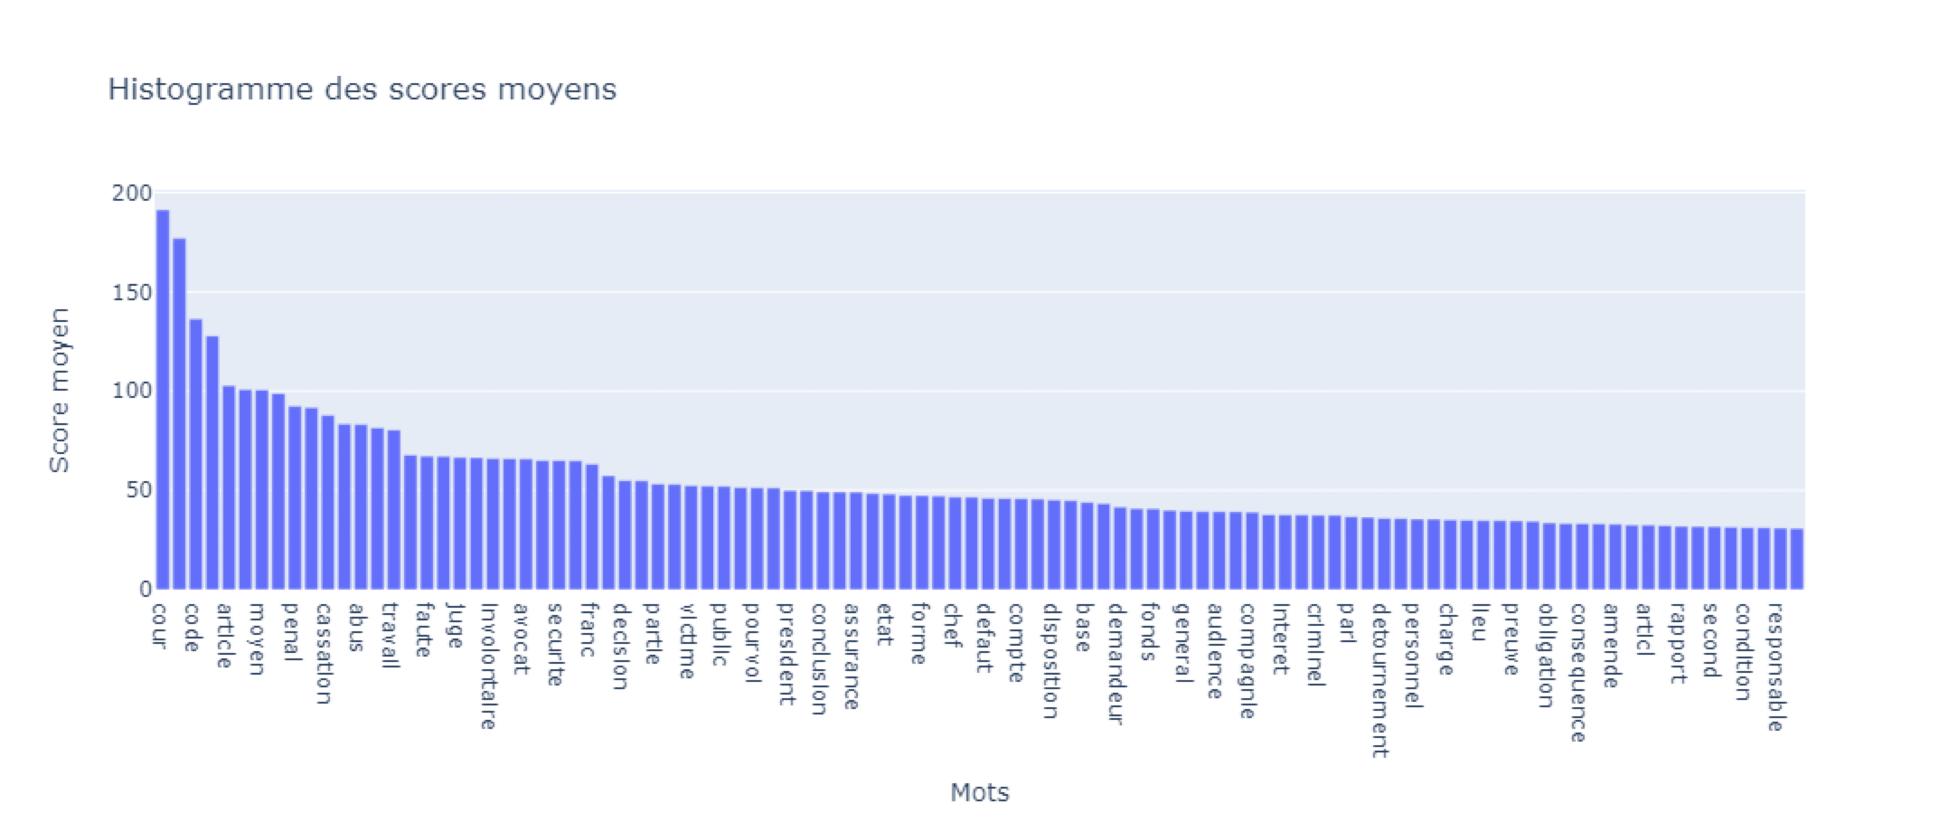

In [32]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np


# Récupération des noms de colonnes (mots)
feature_names = np.array(vec.get_feature_names_out())

# Calcul des scores moyens des mots
mean_scores = np.asarray(tfidf.sum(axis=0)).flatten()

# Tri des scores moyens par ordre décroissant
sorted_scores_idx = mean_scores.argsort()[::-1][:100]

# Récupération des noms des mots triés
sorted_feature_names = [feature_names[i] for i in sorted_scores_idx]

# Récupération des scores moyens triés
sorted_mean_scores = mean_scores[sorted_scores_idx]

# Création de la figure
fig = make_subplots(rows=1, cols=1)

# Ajout de l'histogramme
trace = go.Bar(x=sorted_feature_names[:100], y=sorted_mean_scores[:100])
fig.add_trace(trace)

# Mise en forme de la figure
fig.update_layout(title="Histogramme des scores moyens",
                  xaxis_title="Mots",
                  yaxis_title="Score moyen")

# Affichage de la figure
#fig.show()

plt.figure(figsize=(25,15))
img = mpimg.imread("mot.png")
plt.axis("off")
plt.imshow(img)
plt.show()

## Nuage des mots
Un nuage de mots (ou nuage de tags) en traitement automatique du langage naturel (NLP) est une représentation visuelle des mots qui apparaissent fréquemment dans un texte ou un corpus de texte, où la taille de chaque mot est proportionnelle à sa fréquence d'apparition. Il s'agit d'un moyen intuitif et graphique de mettre en évidence les mots clés ou les concepts les plus importants dans un ensemble de documents.

Voici comment fonctionne généralement la création d'un nuage de mots :

1. Fréquence des mots : Tout d'abord, on calcule la fréquence de chaque mot dans le texte ou le corpus. Les mots les plus fréquents sont ceux qui apparaissent le plus souvent.

2. Sélection des mots : On sélectionne un ensemble de mots à inclure dans le nuage de mots. Cela peut être basé sur la fréquence (par exemple, les 20 mots les plus fréquents), ou on peut spécifier des mots-clés ou des mots spécifiques à inclure.

3. Taille des mots : La taille de chaque mot dans le nuage est déterminée par sa fréquence relative par rapport aux autres mots sélectionnés. Les mots les plus fréquents sont généralement plus grands.

4. Disposition aléatoire ou artistique : Les mots sont disposés de manière aléatoire ou de manière artistique dans l'image du nuage de mots. Certains nuages de mots utilisent également des couleurs pour rendre la représentation plus attrayante.

5. Création de l'image : Une fois que les mots et leur taille sont déterminés, une image du nuage de mots est générée. Cette image peut être statique ou interactive, selon l'outil utilisé.

6. Les nuages de mots sont couramment utilisés pour visualiser rapidement les thèmes ou les sujets principaux d'un corpus de texte. Ils sont utiles pour donner une idée générale du contenu sans avoir à lire chaque document individuellement. Les applications courantes des nuages de mots comprennent l'analyse de sentiment, la recherche d'informations, l'exploration de données textuelles, la visualisation de contenu web, et bien d'autres.

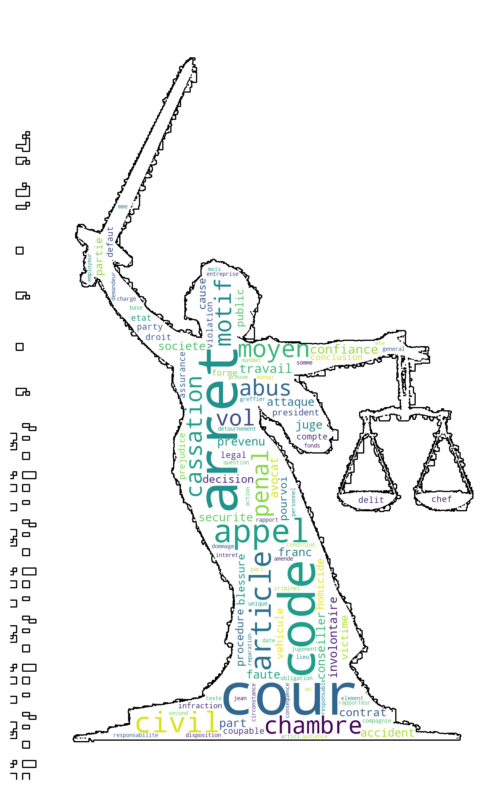

In [30]:
from PIL import Image
from wordcloud import WordCloud
mask = np.array(Image.open("test.jpeg"))
# Création de l'objet WordCloud avec le masque de coeur
wc = WordCloud(background_color="white", max_words=100, mask=mask, contour_width=3, contour_color='black')
# Génération du wordcloud à partir de la matrice TF-IDF
wc.generate_from_frequencies(df.T.sum(axis=1))
# Affichage du wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

## Prédiction de la décision de justice

In [35]:
data_set.head(10)

,Texte,Decision,Date,Categorie,Texte_token
0,rejet pourvoi regulierement forme jacques cont...,rejet,1963-01-04,abus,rejet pourvoi forme jacques arret cour appel r...
1,cassation pourvois jean robert joseph christia...,cassation,1963-01-29,abus,cassation jean robert joseph christian arret c...
2,cassation partielle pourvoi max partie civile ...,cassation,1963-02-26,abus,cassation partiel pourvoi max partie civil arr...
3,rejet pourvoi hugues contre arret cour appel a...,rejet,1963-06-11,abus,rejet pourvoi hugue arret cour appel aix prove...
4,rejet cassation partielle pourvois reguliereme...,cassation,1963-06-27,abus,rejet cassation partiel forme francais transpo...
5,rejet pourvois formes dame michelle epouse phi...,rejet,1964-05-12,abus,rejet forme dame michell philippe arret juille...
6,cassation partielle pourvoi isaac partie civil...,cassation,1964-06-02,abus,cassation partiel pourvoi isaac partie civil a...
7,rejet pourvoi dame veuve partie civile contre ...,rejet,1964-06-25,abus,rejet pourvoi dame veuf partie civil arret cha...
8,rejet pourvoi raymond contre arret cour appel ...,rejet,1964-07-16,abus,rejet pourvoi raymond arret cour appel pari ma...
9,rejet pourvoi yvon contre arret cour appel age...,rejet,1965-03-25,abus,rejet pourvoi yvon arret cour appel agen mai m...


In [39]:
data_set = data_set[["Texte_token", "Categorie", "Decision"]]
data_set.head()

,Texte_token,Categorie,Decision
0,rejet pourvoi forme jacques arret cour appel r...,abus,rejet
1,cassation jean robert joseph christian arret c...,abus,cassation
2,cassation partiel pourvoi max partie civil arr...,abus,cassation
3,rejet pourvoi hugue arret cour appel aix prove...,abus,rejet
4,rejet cassation partiel forme francais transpo...,abus,cassation


In [44]:
data_set["Categorie"].value_counts()

homicide    649
abus        471
vol         420
Name: Categorie, dtype: int64

In [45]:
data_set["Decision"] = data_set["Decision"].replace(["rejet", "cassation"], [0, 1])
data_set["Categorie"] = data_set["Categorie"].replace(["homicide", "abus", "vol"], [1, 2, 3])

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [64]:
vec = TfidfVectorizer(decode_error='ignore', stop_words = "english", max_features=500, lowercase=True, min_df=20, encoding='utf-8')
X = vec.fit_transform(data_set["Texte_token"])
df = pd.DataFrame(X.toarray(), columns=vec.get_feature_names_out())
print(df.head(4))
print(df.shape)

    absence      abus  accident  accord  accusation      acte    action  \
0  0.000000  0.266018       0.0     0.0         0.0  0.000000  0.000000   
1  0.020601  0.197497       0.0     0.0         0.0  0.082158  0.000000   
2  0.052095  0.166477       0.0     0.0         0.0  0.207763  0.112588   
3  0.000000  0.116726       0.0     0.0         0.0  0.000000  0.059206   

   activite  administration  adopte  ...  victime  vie  viol  violation  \
0  0.000000        0.000000     0.0  ...      0.0  0.0   0.0   0.072354   
1  0.032744        0.036962     0.0  ...      0.0  0.0   0.0   0.023874   
2  0.000000        0.000000     0.0  ...      0.0  0.0   0.0   0.060373   
3  0.000000        0.000000     0.0  ...      0.0  0.0   0.0   0.031748   

     vise  vitesse  voie  voiture  vol  vue  
0  0.0000      0.0   0.0      0.0  0.0  0.0  
1  0.0000      0.0   0.0      0.0  0.0  0.0  
2  0.0000      0.0   0.0      0.0  0.0  0.0  
3  0.0736      0.0   0.0      0.0  0.0  0.0  

[4 rows x 500 col

In [69]:
modele_data = df.merge(data_set, left_index=True, right_index=True)
modele_data = modele_data.drop("Texte_token", axis=1)

## Mise en place d'un modèle au choix (aléatoire) : Choix effectuer pour les forêts aléatoire ; la problématique n'étant pas de trouver le meilleur modèle possible. 

In [71]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [72]:
Y = modele_data["Decision"]
X = modele_data.drop(columns= ["Decision"])

In [73]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
# afficher les dimensions des ensembles d'entraînement et de test
print("Dimensions de l'ensemble d'entraînement X_train: ", X_train.shape)
print("Dimensions de l'ensemble de test X_test: ", X_test.shape)
print("Dimensions de l'ensemble d'entraînement y_train: ", y_train.shape)
print("Dimensions de l'ensemble de test y_test: ", y_test.shape)

Dimensions de l'ensemble d'entraînement X_train:  (1037, 501)
Dimensions de l'ensemble de test X_test:  (445, 501)
Dimensions de l'ensemble d'entraînement y_train:  (1037,)
Dimensions de l'ensemble de test y_test:  (445,)


In [77]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score

In [78]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

In [79]:
rf = RandomForestClassifier(random_state=42)

In [80]:
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)

c:\Users\Paqua\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.



GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [82]:
best_params = grid_search.best_params_
print(best_params)

{'max_depth': 30, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}


In [83]:
clf = RandomForestClassifier(max_depth=30, max_features="auto", min_samples_leaf=1, min_samples_split=10, n_estimators=200, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

c:\Users\Paqua\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.



In [84]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      1.00      0.83       316
           1       0.50      0.01      0.02       129

    accuracy                           0.71       445
   macro avg       0.61      0.50      0.42       445
weighted avg       0.65      0.71      0.59       445

[[315   1]
 [128   1]]


In [85]:
from sklearn.metrics import accuracy_score
print('\nAccuracy : %.3f' % accuracy_score(y_test,y_pred))


Accuracy : 0.710


Nous obtenous nous précision de 0.71 pour la prédiction de la décision à partir du corpus de texte. 